# Calling libraries:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gspread
# %pip install gsheets
# import gsheets
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import re
import string
import spacy
import time
import warnings
import seaborn as sns
from spacy import displacy
Text_Visualization = spacy.load('en_core_web_sm')
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from textblob import TextBlob
%pip install emoji
import emoji
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
from yellowbrick.cluster import KElbowVisualizer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [16, 10]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
 !ls /content/drive/MyDrive/1000MLProjects-main/datasets/russian-troll-tweets-master/IRAhandle_tweets_5.gsheet

/content/drive/MyDrive/1000MLProjects-main/datasets/russian-troll-tweets-master/IRAhandle_tweets_5.gsheet


# Read & Data analysis

# Nouvelle section

In [ ]:
#Read data
datasets = pd.read_csv("/content/Tweets.csv",encoding='ISO-8859-1',header=None)
datasets= datasets.sample(10000)
# data.drop(["tweet_id","airline_sentiment"],inplace=True, axis=0)

datasets.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
7450,569602897572450305,negative,1.0,Late Flight,1.0,Delta,NaN,amberfav,NaN,0,"@JetBlue every time I look at the flight status, 30 more minutes is added to the delay. How about some points for trouble??",NaN,2015-02-22 13:01:28 -0800,NaN,Central Time (US & Canada)
10835,568836390991101952,negative,1.0,Customer Service Issue,1.0,US Airways,NaN,lsmith_31,NaN,0,@USAirways Call volumes are high so the best answer is to hang up on me?,"[0.0, 0.0]",2015-02-20 10:15:38 -0800,NaN,Quito
754,570099762709581824,neutral,0.7065,NaN,0.0,United,NaN,FIETA_DOC,NaN,0,@united yes I do.,NaN,2015-02-23 21:55:50 -0800,"Madison, NJ",NaN
2359,569247182337019904,positive,1.0,NaN,NaN,United,NaN,smithnr,NaN,0,@united Rhonda C. at Atlanta airport redeemed you guys. She got us straightened out.,NaN,2015-02-21 13:27:59 -0800,"31.790466, -85.971558",Central Time (US & Canada)
10034,569562007671853056,negative,1.0,Customer Service Issue,1.0,US Airways,NaN,FvGrecia,NaN,1,@USAirways @MrRenevendez I've been trying to contact them for 24 hours already! Yesterday I waited 7 hours today 5+! http://t.co/gn30p75KqB,NaN,2015-02-22 10:18:59 -0800,NaN,NaN


In [ ]:
#create a name for each column to modify them easy

datasets.columns= ["tweet_id","Target","airline_sentiment_confidence","negativereason","negativereason_confidence","airline","airline_sentiment_gold","name","negativereason_gold","retweet_count","text","tweet_coord","tweet_created","tweet_location","user_timezone"]
datasets.head()

,tweet_id,Target,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
7450,569602897572450305,negative,1.0,Late Flight,1.0,Delta,NaN,amberfav,NaN,0,"@JetBlue every time I look at the flight status, 30 more minutes is added to the delay. How about some points for trouble??",NaN,2015-02-22 13:01:28 -0800,NaN,Central Time (US & Canada)
10835,568836390991101952,negative,1.0,Customer Service Issue,1.0,US Airways,NaN,lsmith_31,NaN,0,@USAirways Call volumes are high so the best answer is to hang up on me?,"[0.0, 0.0]",2015-02-20 10:15:38 -0800,NaN,Quito
754,570099762709581824,neutral,0.7065,NaN,0.0,United,NaN,FIETA_DOC,NaN,0,@united yes I do.,NaN,2015-02-23 21:55:50 -0800,"Madison, NJ",NaN
2359,569247182337019904,positive,1.0,NaN,NaN,United,NaN,smithnr,NaN,0,@united Rhonda C. at Atlanta airport redeemed you guys. She got us straightened out.,NaN,2015-02-21 13:27:59 -0800,"31.790466, -85.971558",Central Time (US & Canada)
10034,569562007671853056,negative,1.0,Customer Service Issue,1.0,US Airways,NaN,FvGrecia,NaN,1,@USAirways @MrRenevendez I've been trying to contact them for 24 hours already! Yesterday I waited 7 hours today 5+! http://t.co/gn30p75KqB,NaN,2015-02-22 10:18:59 -0800,NaN,NaN


In [ ]:
# Define a dictionary to map values
value_mapping = {'negative': -1, 'positive': 1, 'neutral': 0}

# Replace values in the specific column ('airline_sentiment') using the map method
column_txt_sent = 'Target'
if column_txt_sent in datasets.columns:
    datasets[column_txt_sent] = datasets[column_txt_sent].map(value_mapping)

# Save the modified DataFrame back to a CSV file if needed
datasets.to_csv('tweets.csv', index=False)


In [ ]:
datasets.head()

,tweet_id,Target,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
5469,568969143581413376,positive,1.0,NaN,NaN,Southwest,NaN,tikidaisy,NaN,0,@SouthwestAir Well plane arrived pretty much on time and it's 68 degrees on the ground in Texas. Not much to complain about.,"[30.30630631, -97.71394697]",2015-02-20 19:03:09 -0800,"Washington, DC",America/New_York
10467,569274088289660928,negative,1.0,Customer Service Issue,1.0,US Airways,NaN,beychok,NaN,0,"@USAirways it a change fee request from a month ago. after one hour on phone with your team, Iâm told 120 day backlog. Awful.",NaN,2015-02-21 15:14:53 -0800,Washington DC,Central Time (US & Canada)
2560,569078332278513665,negative,0.664,Can't Tell,0.3423,United,NaN,DaRenton,NaN,0,"@united UA 1706 there is no way a plane ""loses its software"" I believe you decided to do an upgrade...",NaN,2015-02-21 02:17:02 -0800,Colorado,Mountain Time (US & Canada)
14371,569626388610859008,negative,1.0,Customer Service Issue,0.6568,American,NaN,dave_dcollins,NaN,0,@AmericanAir I have been on hold 3 hours. 2 seconds of it with a rude agent.,NaN,2015-02-22 14:34:48 -0800,NaN,NaN
4529,570062210640322560,negative,0.3499,Can't Tell,0.3499,Southwest,NaN,sammyboy405,NaN,0,@SouthwestAir your welcome. It was the thoughts of nearly the entire plane.,NaN,2015-02-23 19:26:36 -0800,"Mustang, Oklahoma",NaN


In [ ]:
#data information
print(datasets.shape)
print("....................................")
print(datasets.describe())
print("....................................")
datasets.info()
print("....................................")
print(datasets.dtypes)

(10000, 15)
....................................
            Target
count  9999.000000
mean     -0.463146
std       0.756394
min      -1.000000
25%      -1.000000
50%      -1.000000
75%       0.000000
max       1.000000
....................................
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 7450 to 703
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      10000 non-null  object 
 1   Target                        9999 non-null   float64
 2   airline_sentiment_confidence  10000 non-null  object 
 3   negativereason                6249 non-null   object 
 4   negativereason_confidence     7174 non-null   object 
 5   airline                       10000 non-null  object 
 6   airline_sentiment_gold        31 non-null     object 
 7   name                          10000 non-null  object 
 8   negativereason_gold           23 non-n

In [ ]:
#no. of Target values
# datasets["airline_sentiment"].value_counts()

# data_col_upd=datasets["airline_sentiment"]




In [ ]:
datasets

,tweet_id,Target,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
5469,568969143581413376,positive,1.0,NaN,NaN,Southwest,NaN,tikidaisy,NaN,0,@SouthwestAir Well plane arrived pretty much on time and it's 68 degrees on the ground in Texas. Not much to complain about.,"[30.30630631, -97.71394697]",2015-02-20 19:03:09 -0800,"Washington, DC",America/New_York
10467,569274088289660928,negative,1.0,Customer Service Issue,1.0,US Airways,NaN,beychok,NaN,0,"@USAirways it a change fee request from a month ago. after one hour on phone with your team, Iâm told 120 day backlog. Awful.",NaN,2015-02-21 15:14:53 -0800,Washington DC,Central Time (US & Canada)
2560,569078332278513665,negative,0.664,Can't Tell,0.3423,United,NaN,DaRenton,NaN,0,"@united UA 1706 there is no way a plane ""loses its software"" I believe you decided to do an upgrade...",NaN,2015-02-21 02:17:02 -0800,Colorado,Mountain Time (US & Canada)
14371,569626388610859008,negative,1.0,Customer Service Issue,0.6568,American,NaN,dave_dcollins,NaN,0,@AmericanAir I have been on hold 3 hours. 2 seconds of it with a rude agent.,NaN,2015-02-22 14:34:48 -0800,NaN,NaN
4529,570062210640322560,negative,0.3499,Can't Tell,0.3499,Southwest,NaN,sammyboy405,NaN,0,@SouthwestAir your welcome. It was the thoughts of nearly the entire plane.,NaN,2015-02-23 19:26:36 -0800,"Mustang, Oklahoma",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9041,570273188485197825,negative,0.6674,Late Flight,0.6674,US Airways,NaN,SteveBass2,NaN,0,"@USAirways ...2 hours on the plane, they at least got us on a direct flight a couple hours Late Flightr on United","[40.6954621, -74.1733106]",2015-02-24 09:24:57 -0800,NaN,NaN
826,570063574858493952,negative,1.0,Lost Luggage,1.0,United,NaN,PreyingMantis02,NaN,0,@united yes I filed a claim &amp; hope to receive by luggage by 2am. Ridiculous as I had to purchase items to go to sleep &amp; no reimbursement.,NaN,2015-02-23 19:32:02 -0800,NaN,NaN
3039,568784261064622080,neutral,1.0,NaN,NaN,United,NaN,Easy_E_,NaN,0,@united Hi. My 2/23 flight from CUN-EWR shows a departure of 2:55pm on my United app. Can you confirm? Doesn't look correct. Thanks.,NaN,2015-02-20 06:48:29 -0800,Tri State NY area...,Eastern Time (US & Canada)
3549,568275733736353792,neutral,0.6511,NaN,0.0,United,NaN,annemariee46,NaN,0,@united hey I left my favorite blanket on the plane bring it back home to me:-(,NaN,2015-02-18 21:07:47 -0800,NaN,Hawaii




```
# Ce texte est au format code
```

# Cleaning Data

*italicized text*[texte du lien](https://)<font color='red'><font

*   Élément de liste
*   Élément de liste

size = 5 >Start Cleaning our data</font>

<font color='blue'><font size = 2 >     1. Lowercasing all the letters</font>

In [ ]:
datasets['data'] = datasets['text'].str.lower()
display(datasets)

,tweet_id,Target,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,data
7450,569602897572450305,-1.0,1.0,Late Flight,1.0,Delta,NaN,amberfav,NaN,0,"@JetBlue every time I look at the flight status, 30 more minutes is added to the delay. How about some points for trouble??",NaN,2015-02-22 13:01:28 -0800,NaN,Central Time (US & Canada),"@jetblue every time i look at the flight status, 30 more minutes is added to the delay. how about some points for trouble??"
10835,568836390991101952,-1.0,1.0,Customer Service Issue,1.0,US Airways,NaN,lsmith_31,NaN,0,@USAirways Call volumes are high so the best answer is to hang up on me?,"[0.0, 0.0]",2015-02-20 10:15:38 -0800,NaN,Quito,@usairways call volumes are high so the best answer is to hang up on me?
754,570099762709581824,0.0,0.7065,NaN,0.0,United,NaN,FIETA_DOC,NaN,0,@united yes I do.,NaN,2015-02-23 21:55:50 -0800,"Madison, NJ",NaN,@united yes i do.
2359,569247182337019904,1.0,1.0,NaN,NaN,United,NaN,smithnr,NaN,0,@united Rhonda C. at Atlanta airport redeemed you guys. She got us straightened out.,NaN,2015-02-21 13:27:59 -0800,"31.790466, -85.971558",Central Time (US & Canada),@united rhonda c. at atlanta airport redeemed you guys. she got us straightened out.
10034,569562007671853056,-1.0,1.0,Customer Service Issue,1.0,US Airways,NaN,FvGrecia,NaN,1,@USAirways @MrRenevendez I've been trying to contact them for 24 hours already! Yesterday I waited 7 hours today 5+! http://t.co/gn30p75KqB,NaN,2015-02-22 10:18:59 -0800,NaN,NaN,@usairways @mrrenevendez i've been trying to contact them for 24 hours already! yesterday i waited 7 hours today 5+! http://t.co/gn30p75kqb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470,570176104541122561,-1.0,1.0,Flight Attendant Complaints,1.0,American,NaN,SouthSeth,NaN,0,@AmericanAir merged airlines do not work for FF programs. Very frustrating and the gate agents are to busy pouting to care. #AttitudeIssues,NaN,2015-02-24 02:59:11 -0800,Crestwood,Eastern Time (US & Canada),@americanair merged airlines do not work for ff programs. very frustrating and the gate agents are to busy pouting to care. #attitudeissues
13271,569899646509666304,-1.0,1.0,Bad Flight,0.6737,American,NaN,gingermc23,NaN,0,"@AmericanAir confused at the definition of a ""preferred seat."" I paid extra for one and got a regular seat with no legroom. Unimpressed.",NaN,2015-02-23 08:40:38 -0800,milford.,Eastern Time (US & Canada),"@americanair confused at the definition of a ""preferred seat."" i paid extra for one and got a regular seat with no legroom. unimpressed."
10138,569525480178769920,-1.0,1.0,Customer Service Issue,0.6703,US Airways,NaN,ClaudOakeshott,NaN,0,@USAirways you can't control the weather but you can control customer service. Without luggage for 24 hours &amp; still yet to speak to a human.,NaN,2015-02-22 07:53:50 -0800,Washington DC,NaN,@usairways you can't control the weather but you can control customer service. without luggage for 24 hours &amp; still yet to speak to a human.
8619,568107407647207424,-1.0,0.6747,Damaged Luggage,0.6747,Delta,NaN,LisaPal,NaN,0,@JetBlue but you guys should know that musicians are very sensitive about the safety of their instruments when flying. For good reason.,NaN,2015-02-18 09:58:55 -0800,"New Orleans, LA",Central Time (US & Canada),@jetblue but you guys should know that musicians are very sensitive about the safety of their instruments when flying. for good reason.


<font color='blue'><font size = 2 >2.Removing Consecutive letters</font>


In [ ]:
#Removing Consecutive letters: 3 or more consecutive letters are replaced by 2 letters. (eg: "hellooo" to "Hellooo")
#cause some words like "all" if we replaced "ll" with only one "l" will lose the meaning
#str = "hellooooo"
#print(re.sub(r"(.)\1\1+", r"\1\1", str))
#output will be : hello

def cleaning_repeating_char(text):
    return re.sub(r'(.)\1\1+', r'\1\1', text)
datasets['data'] = datasets['data'].apply(lambda x: cleaning_repeating_char(x))
datasets['data'].tail()


12470         @americanair merged airlines do not work for ff programs. very frustrating and the gate agents are to busy pouting to care. #attitudeissues
13271            @americanair confused at the definition of a "preferred seat." i paid extra for one and got a regular seat with no legroom. unimpressed.
10138    @usairways you can't control the weather but you can control customer service. without luggage for 24 hours &amp; still yet to speak to a human.
8619              @jetblue but you guys should know that musicians are very sensitive about the safety of their instruments when flying. for good reason.
703            @united so if i'm flying 1st class just one leg to chicago but not on my long flight to china am i still able to use the lounge in chicago
Name: data, dtype: object

<font color='blue'><font size = 2 >3.Replace all emojis </font>


In [ ]:
#ex: The emoji 💣 or the shortcode :bomb: will be converted to "bomba" its meaning in English by demojize()
datasets['data'] = datasets['data'].apply(lambda x: emoji.demojize(x,language='es'))
datasets['data'].tail()


12470         @americanair merged airlines do not work for ff programs. very frustrating and the gate agents are to busy pouting to care. #attitudeissues
13271            @americanair confused at the definition of a "preferred seat." i paid extra for one and got a regular seat with no legroom. unimpressed.
10138    @usairways you can't control the weather but you can control customer service. without luggage for 24 hours &amp; still yet to speak to a human.
8619              @jetblue but you guys should know that musicians are very sensitive about the safety of their instruments when flying. for good reason.
703            @united so if i'm flying 1st class just one leg to chicago but not on my long flight to china am i still able to use the lounge in chicago
Name: data, dtype: object

<font color='blue'><font size = 2 >4. Remove Hashtags</font>

In [ ]:
def cleaning_hashtag(hash):
    hash_pattern = re.compile(r'#[A-Za-z0-9_]+')
    return hash_pattern.sub(r'', hash)
datasets['data'] = datasets['data'].apply(lambda x: cleaning_hashtag(x))
datasets['data'].tail()

12470                        @americanair merged airlines do not work for ff programs. very frustrating and the gate agents are to busy pouting to care. 
13271            @americanair confused at the definition of a "preferred seat." i paid extra for one and got a regular seat with no legroom. unimpressed.
10138    @usairways you can't control the weather but you can control customer service. without luggage for 24 hours &amp; still yet to speak to a human.
8619              @jetblue but you guys should know that musicians are very sensitive about the safety of their instruments when flying. for good reason.
703            @united so if i'm flying 1st class just one leg to chicago but not on my long flight to china am i still able to use the lounge in chicago
Name: data, dtype: object

In [ ]:

def cleaning_ment(ment):
    ment_pattern = re.compile(r'@[A-Za-z0-9_]')
    return ment_pattern.sub(r'', ment)
datasets['data'] = datasets['data'].apply(lambda x: cleaning_ment(x))
datasets['data']


7450                          etblue every time i look at the flight status, 30 more minutes is added to the delay. how about some points for trouble??
10835                                                                            sairways call volumes are high so the best answer is to hang up on me?
754                                                                                                                                     nited yes i do.
2359                                                                 nited rhonda c. at atlanta airport redeemed you guys. she got us straightened out.
10034           sairways rrenevendez i've been trying to contact them for 24 hours already! yesterday i waited 7 hours today 5+! http://t.co/gn30p75kqb
                                                                              ...                                                                      
12470                        mericanair merged airlines do not work for ff programs. ver

<font color='blue'><font size = 2 >5. Remove @ or mentions</font>

<font color='blue'><font size = 2 >6. Remove links</font>

In [ ]:
def cleaning_lnk(lnk):
    lnk_pattern = re.compile(r'http\S+|www.\S+|<.*?>')
    return lnk_pattern.sub(r'', lnk)
datasets['data'] = datasets['data'].apply(lambda x: cleaning_lnk(x))
datasets['data'].tail()

12470                        mericanair merged airlines do not work for ff programs. very frustrating and the gate agents are to busy pouting to care. 
13271            mericanair confused at the definition of a "preferred seat." i paid extra for one and got a regular seat with no legroom. unimpressed.
10138    sairways you can't control the weather but you can control customer service. without luggage for 24 hours &amp; still yet to speak to a human.
8619              etblue but you guys should know that musicians are very sensitive about the safety of their instruments when flying. for good reason.
703            nited so if i'm flying 1st class just one leg to chicago but not on my long flight to china am i still able to use the lounge in chicago
Name: data, dtype: object

# Visualization

<font color='blue'><font size = 2 >Visualizing the dependency</font>

In [ ]:
doc_dep = datasets["data"][:5].apply(lambda x: Text_Visualization(x))
option_dep ={'distance': 100, "color": "#30c8b6", "bg": "#193380", "font": "Arial"}
displacy.render(doc_dep, style='dep', jupyter=True, options=option_dep)

<font color='blue'><font size = 2 >Visualizing the entity recognizer</font>

In [ ]:
doc_ent = datasets["data"][:10].apply(lambda x: Text_Visualization(x))
#doc_ent.user_data["title"] = "ENT"
displacy.render(doc_ent, style='ent', jupyter=True)

<font color='blue'><font size = 2 >7. Remove puctuations and non-alphanumeric</font>

In [ ]:
#remove (anything not alphanumeric,whitespace or digit)
def cleaning_punc(punc):
    for char in string.punctuation:
        punc = punc.replace(char, '')
    return punc
datasets['data'] = datasets['data'].apply(cleaning_punc)
datasets['data'].tail()

12470                     mericanair merged airlines do not work for ff programs very frustrating and the gate agents are to busy pouting to care 
13271            mericanair confused at the definition of a preferred seat i paid extra for one and got a regular seat with no legroom unimpressed
10138    sairways you cant control the weather but you can control customer service without luggage for 24 hours amp still yet to speak to a human
8619           etblue but you guys should know that musicians are very sensitive about the safety of their instruments when flying for good reason
703        nited so if im flying 1st class just one leg to chicago but not on my long flight to china am i still able to use the lounge in chicago
Name: data, dtype: object

<font color='blue'><font size = 2 >8.Tokenization </font>

In [ ]:
#Tokenization
datasets['data'] = datasets['data'].apply(lambda x: word_tokenize(x))
datasets['data'].tail()

12470                             [mericanair, merged, airlines, do, not, work, for, ff, programs, very, frustrating, and, the, gate, agents, are, to, busy, pouting, to, care]
13271                 [mericanair, confused, at, the, definition, of, a, preferred, seat, i, paid, extra, for, one, and, got, a, regular, seat, with, no, legroom, unimpressed]
10138       [sairways, you, cant, control, the, weather, but, you, can, control, customer, service, without, luggage, for, 24, hours, amp, still, yet, to, speak, to, a, human]
8619                 [etblue, but, you, guys, should, know, that, musicians, are, very, sensitive, about, the, safety, of, their, instruments, when, flying, for, good, reason]
703      [nited, so, if, im, flying, 1st, class, just, one, leg, to, chicago, but, not, on, my, long, flight, to, china, am, i, still, able, to, use, the, lounge, in, chicago]
Name: data, dtype: object

<font color='blue'><font size = 2 >9.Remove Stop Words </font>

In [ ]:
# Import stopwords with scikit-learn
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS

In [ ]:
tokenword = datasets['text'].apply(lambda x: word_tokenize(x))
res = datasets['data']
res

7450                              [etblue, every, time, i, look, at, the, flight, status, 30, more, minutes, is, added, to, the, delay, how, about, some, points, for, trouble]
10835                                                                                     [sairways, call, volumes, are, high, so, the, best, answer, is, to, hang, up, on, me]
754                                                                                                                                                         [nited, yes, i, do]
2359                                                                             [nited, rhonda, c, at, atlanta, airport, redeemed, you, guys, she, got, us, straightened, out]
10034                                          [sairways, rrenevendez, ive, been, trying, to, contact, them, for, 24, hours, already, yesterday, i, waited, 7, hours, today, 5]
                                                                                          ...                           

In [ ]:
print('Tokenized words:\n ',tokenword)
print("....................................")
print('\nNo-Stopwords:\n ',res)
print("....................................")
datasets

Tokenized words:
  7450                              [@, JetBlue, every, time, I, look, at, the, flight, status, ,, 30, more, minutes, is, added, to, the, delay, ., How, about, some, points, for, trouble, ?, ?]
10835                                                                                              [@, USAirways, Call, volumes, are, high, so, the, best, answer, is, to, hang, up, on, me, ?]
754                                                                                                                                                                  [@, united, yes, I, do, .]
2359                                                                                  [@, united, Rhonda, C., at, Atlanta, airport, redeemed, you, guys, ., She, got, us, straightened, out, .]
10034            [@, USAirways, @, MrRenevendez, I, 've, been, trying, to, contact, them, for, 24, hours, already, !, Yesterday, I, waited, 7, hours, today, 5+, !, http, :, //t.co/gn30p75KqB]
                     

,tweet_id,Target,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,data
7450,569602897572450305,-1.0,1.0,Late Flight,1.0,Delta,NaN,amberfav,NaN,0,"@JetBlue every time I look at the flight status, 30 more minutes is added to the delay. How about some points for trouble??",NaN,2015-02-22 13:01:28 -0800,NaN,Central Time (US & Canada),"[etblue, every, time, i, look, at, the, flight, status, 30, more, minutes, is, added, to, the, delay, how, about, some, points, for, trouble]"
10835,568836390991101952,-1.0,1.0,Customer Service Issue,1.0,US Airways,NaN,lsmith_31,NaN,0,@USAirways Call volumes are high so the best answer is to hang up on me?,"[0.0, 0.0]",2015-02-20 10:15:38 -0800,NaN,Quito,"[sairways, call, volumes, are, high, so, the, best, answer, is, to, hang, up, on, me]"
754,570099762709581824,0.0,0.7065,NaN,0.0,United,NaN,FIETA_DOC,NaN,0,@united yes I do.,NaN,2015-02-23 21:55:50 -0800,"Madison, NJ",NaN,"[nited, yes, i, do]"
2359,569247182337019904,1.0,1.0,NaN,NaN,United,NaN,smithnr,NaN,0,@united Rhonda C. at Atlanta airport redeemed you guys. She got us straightened out.,NaN,2015-02-21 13:27:59 -0800,"31.790466, -85.971558",Central Time (US & Canada),"[nited, rhonda, c, at, atlanta, airport, redeemed, you, guys, she, got, us, straightened, out]"
10034,569562007671853056,-1.0,1.0,Customer Service Issue,1.0,US Airways,NaN,FvGrecia,NaN,1,@USAirways @MrRenevendez I've been trying to contact them for 24 hours already! Yesterday I waited 7 hours today 5+! http://t.co/gn30p75KqB,NaN,2015-02-22 10:18:59 -0800,NaN,NaN,"[sairways, rrenevendez, ive, been, trying, to, contact, them, for, 24, hours, already, yesterday, i, waited, 7, hours, today, 5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470,570176104541122561,-1.0,1.0,Flight Attendant Complaints,1.0,American,NaN,SouthSeth,NaN,0,@AmericanAir merged airlines do not work for FF programs. Very frustrating and the gate agents are to busy pouting to care. #AttitudeIssues,NaN,2015-02-24 02:59:11 -0800,Crestwood,Eastern Time (US & Canada),"[mericanair, merged, airlines, do, not, work, for, ff, programs, very, frustrating, and, the, gate, agents, are, to, busy, pouting, to, care]"
13271,569899646509666304,-1.0,1.0,Bad Flight,0.6737,American,NaN,gingermc23,NaN,0,"@AmericanAir confused at the definition of a ""preferred seat."" I paid extra for one and got a regular seat with no legroom. Unimpressed.",NaN,2015-02-23 08:40:38 -0800,milford.,Eastern Time (US & Canada),"[mericanair, confused, at, the, definition, of, a, preferred, seat, i, paid, extra, for, one, and, got, a, regular, seat, with, no, legroom, unimpressed]"
10138,569525480178769920,-1.0,1.0,Customer Service Issue,0.6703,US Airways,NaN,ClaudOakeshott,NaN,0,@USAirways you can't control the weather but you can control customer service. Without luggage for 24 hours &amp; still yet to speak to a human.,NaN,2015-02-22 07:53:50 -0800,Washington DC,NaN,"[sairways, you, cant, control, the, weather, but, you, can, control, customer, service, without, luggage, for, 24, hours, amp, still, yet, to, speak, to, a, human]"
8619,568107407647207424,-1.0,0.6747,Damaged Luggage,0.6747,Delta,NaN,LisaPal,NaN,0,@JetBlue but you guys should know that musicians are very sensitive about the safety of their instruments when flying. For good reason.,NaN,2015-02-18 09:58:55 -0800,"New Orleans, LA",Central Time (US & Canada),"[etblue, but, you, guys, should, know, that, musicians, are, very, sensitive, about, the, safety, of, their, instruments, when, flying, for, good, reason]"


In [ ]:
# add new column 'results' to asign 'post' column without stop words
datasets['data']= datasets['data'].apply(lambda x: [item for item in x if item not in stop])
datasets['data']

7450                               [etblue, time, look, flight, status, 30, minutes, added, delay, points, trouble]
10835                                                                 [sairways, volumes, high, best, answer, hang]
754                                                                                                    [nited, yes]
2359                                        [nited, rhonda, c, atlanta, airport, redeemed, guys, got, straightened]
10034               [sairways, rrenevendez, ive, trying, contact, 24, hours, yesterday, waited, 7, hours, today, 5]
                                                            ...                                                    
12470            [mericanair, merged, airlines, work, ff, programs, frustrating, gate, agents, busy, pouting, care]
13271    [mericanair, confused, definition, preferred, seat, paid, extra, got, regular, seat, legroom, unimpressed]
10138               [sairways, control, weather, control, customer, serv

In [ ]:
# datasets['text'] = datasets['text'].apply(lambda x: ' '.join(x))
datasets['data'] = datasets['data'].apply(lambda x: ' '.join(x))
datasets['data']

7450                              etblue time look flight status 30 minutes added delay points trouble
10835                                                           sairways volumes high best answer hang
754                                                                                          nited yes
2359                                     nited rhonda c atlanta airport redeemed guys got straightened
10034                sairways rrenevendez ive trying contact 24 hours yesterday waited 7 hours today 5
                                                     ...                                              
12470            mericanair merged airlines work ff programs frustrating gate agents busy pouting care
13271    mericanair confused definition preferred seat paid extra got regular seat legroom unimpressed
10138               sairways control weather control customer service luggage 24 hours amp speak human
8619                        etblue guys know musicians sensitive safety i

In [ ]:
type(datasets.data.values)

numpy.ndarray

In [ ]:
type(datasets.text)

pandas.core.series.Series

In [ ]:
df = datasets[datasets['data'].notnull()]
from sklearn import preprocessing
pr = preprocessing.LabelEncoder()
df['data'] = pr.fit_transform(df.data.values)
df['data']

7450     1147
10835    9476
754      5945
2359     5258
10034    9100
         ... 
12470    2699
13271    2024
10138    8009
8619      527
703      4669
Name: data, Length: 10000, dtype: int64

t-Distributed Stochastic Neighbor Embedding

In [ ]:
# tsne code from this great kernel: https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
# New_df is from the random undersample data (fewer instances)
import time
from sklearn.manifold import TSNE
X = df['data']
y = df['Target']
# X_reshaped = X.values.reshape(-1, 1)


# # T-SNE Implementation
# t_0 = time.time()
# X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_reshaped)
# t_1 = time.time()
# print("T-SNE took {:.2} s".format(t_1 - t_0))


# from sklearn.manifold import TSNE

# Assuming X is your 1D dataset
X_reshaped = X.values.reshape(-1, 1)

# T-SNE Implementation with n_components=1 for visualization
t_0 = time.time()
X_reduced_tsne = TSNE(n_components=1, random_state=42).fit_transform(X_reshaped)
t_1 = time.time()
print("T-SNE took {:.2} s".format(t_1 - t_0))


T-SNE took 3.7e+01 s


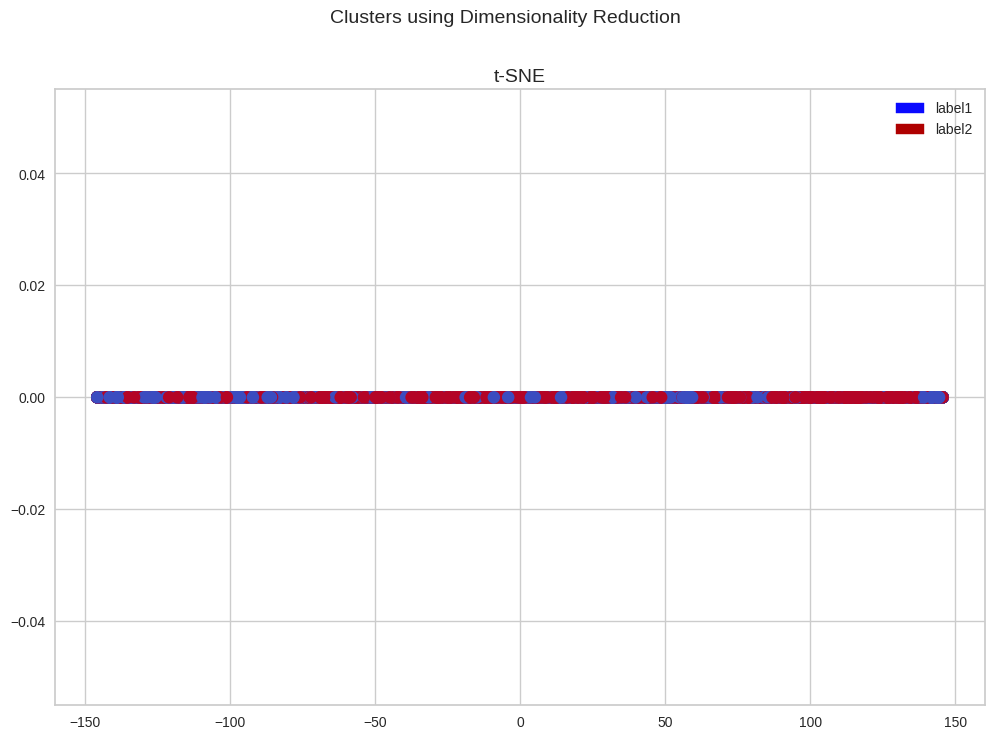

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(12,8))
# labels = ['Label1', 'Label2']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='label1')
red_patch = mpatches.Patch(color='#AF0000', label='label2')


# # t-SNE scatter plot
# ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='label1', linewidths=2)
# ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 4), cmap='coolwarm', label='label2', linewidths=2)
ax1.scatter(X_reduced_tsne, np.zeros_like(X_reduced_tsne), c=(y == 1), cmap='coolwarm', label='label1', linewidths=2)
# ax1.scatter(X_reduced_tsne, np.zeros_like(X_reduced_tsne), c=(y == 0), cmap='coolwarm', label='label1', linewidths=2)
ax1.scatter(X_reduced_tsne, np.zeros_like(X_reduced_tsne), c=(y == -1), cmap='coolwarm', label='label1', linewidths=2)


ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)
# ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='label1', linewidths=2)
# ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 4), cmap='coolwarm', label='label2', linewidths=2)

ax1.legend(handles=[blue_patch, red_patch])


plt.show()

In [ ]:
reindexed_data = datasets['text'] #.str.decode("utf-8", errors="ignore")

In [ ]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii',errors="ignore").decode('utf-8',errors="ignore") for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

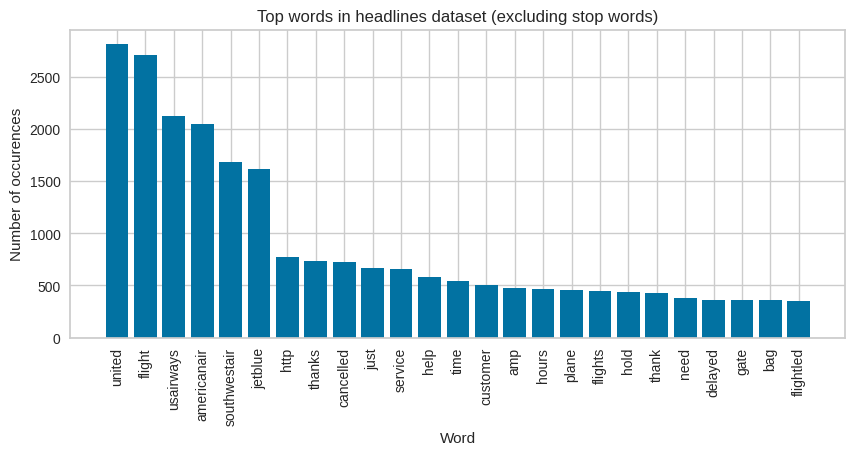

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=25,
                                     count_vectorizer=count_vectorizer,
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

# Using NLP Tools

# TFIDF

In [ ]:
vec = TfidfVectorizer(stop_words="english")

vec.fit(datasets.text.values)
features = vec.transform(datasets.data.values)

In [ ]:
features.shape

(10000, 11956)

# clustering

### MiniBatchKMeans:

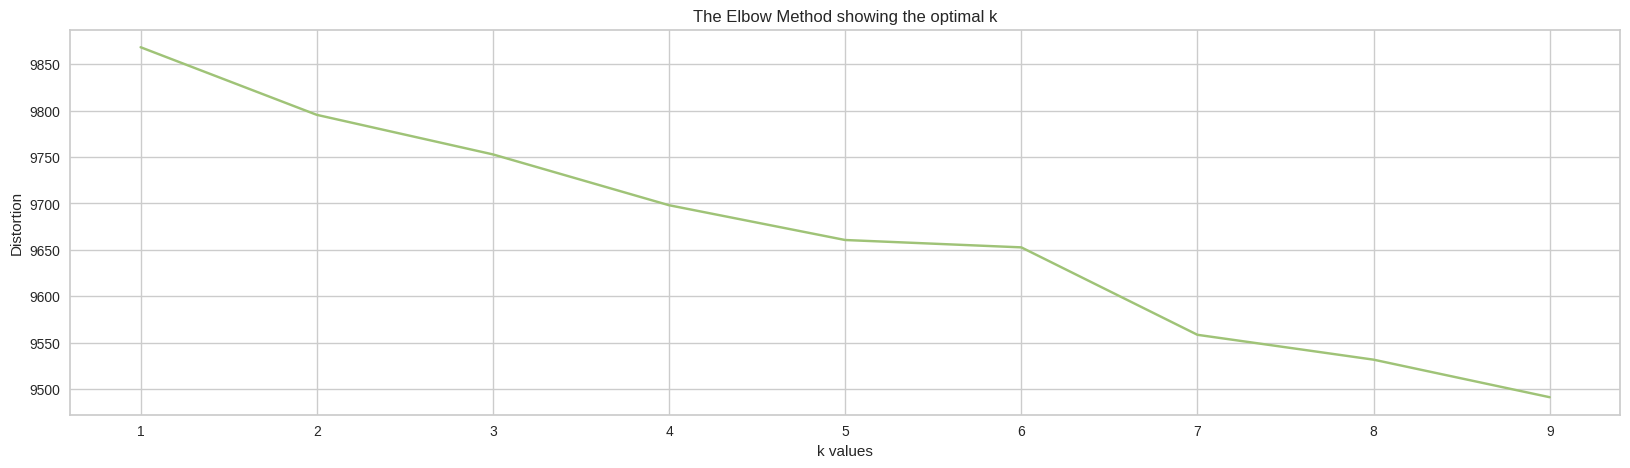

In [ ]:
distortions = []
K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k,random_state=7)
    kmean.fit(features)
    distortions.append(kmean.inertia_)

plt.figure(figsize=(20,5))
plt.plot(K, distortions, '-',color='g')
plt.xlabel('k values')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
cls = MiniBatchKMeans(3,random_state=1000, max_iter= 200)
cls.fit(features)

MiniBatchKMeans(max_iter=200, n_clusters=3, random_state=1000)

In [ ]:
y_predict = cls.predict(features)

In [ ]:
cls.cluster_centers_

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.93701316e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.51701915e-05, 3.59513590e-04, 3.44107691e-04]])

In [ ]:
len(cls.cluster_centers_) , len(cls.cluster_centers_[0])

(3, 11956)

# PCA

In [ ]:
pca = PCA(n_components=2)
PCA = pca.fit(features.toarray())
X_pca = pca.transform(features.toarray())

In [ ]:
X_pca

array([[-0.02271899, -0.0463931 ],
       [ 0.00334832, -0.01048598],
       [ 0.00346372, -0.00786974],
       ...,
       [-0.00713023, -0.02913574],
       [-0.00285896, -0.00232479],
       [-0.02395713, -0.04919531]])

In [ ]:
len(X_pca) , len(X_pca[0])


(10000, 2)

In [ ]:
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
reduced_cluster_centers

array([[ 0.0031175 ,  0.00624447],
       [-0.02772605, -0.03946332],
       [ 0.00948711,  0.01332199]])

# KMEANS

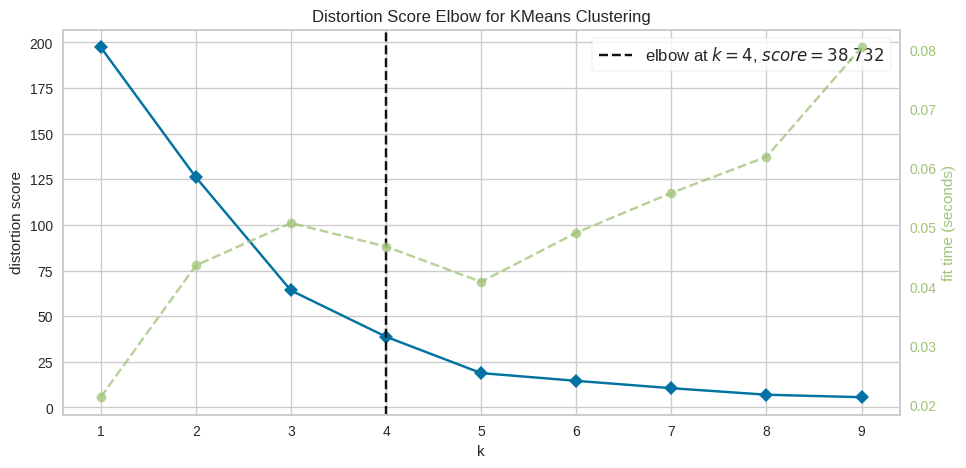

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10),size=(1080, 500))

visualizer.fit(X_pca)
visualizer.show()

In [ ]:
kmeanModel = KMeans(n_clusters=3,random_state=1000)
kmeanModel.fit(X_pca)
pred_labels = kmeanModel.labels_;
pred_centers = kmeanModel.cluster_centers_
df_centers = pd.DataFrame(pred_centers, columns=['x', 'y'])
df_centers.head(1)

,x,y
0,-0.004977,-0.02186


In [ ]:
dfcl = pd.DataFrame(columns=['x','y','label'])
dfcl['x'] = X_pca[:,0]
dfcl['y'] = X_pca[:,1]
dfcl['label'] = kmeanModel.labels_
dfcl.head(1)

,x,y,label
0,-0.022719,-0.046393,0


Text(0.5, 1.0, 'scatter plot')

<Figure size 2000x800 with 0 Axes>

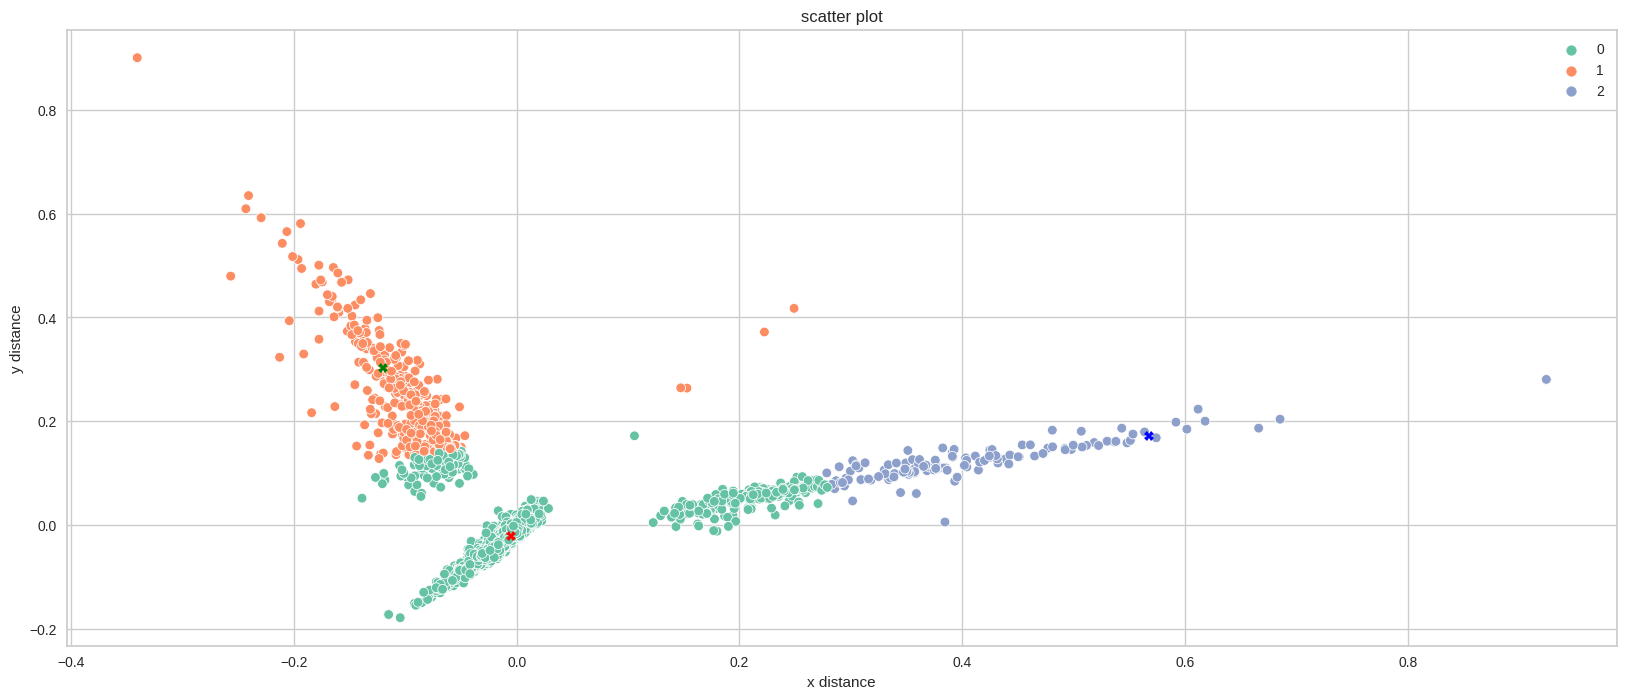

In [ ]:
plt.figure(figsize=(20,8))

# sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=pred_labels.tolist(),palette='Set2')
# colors = ['red', 'green', 'blue', 'yellow']


# for i,color in enumerate(df_centers.index.tolist()):
#     plt.plot(df_centers['x'][i], df_centers['y'][i], 'X', label='K-means center: %d' % i, color=colors[i])
# plt.xlabel('x distance')
# plt.ylabel('y distance')
# plt.title('scatter plot')


plt.figure(figsize=(20, 8))

# Assuming X_pca is your PCA-transformed data and pred_labels is your cluster labels
# Use X_pca[:, 0] and X_pca[:, 1] for the x and y coordinates
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=pred_labels.tolist(), palette='Set2')

colors = ['red', 'green', 'blue', 'yellow']

for i, color in enumerate(df_centers.index.tolist()):
    plt.plot(df_centers['x'][i], df_centers['y'][i], 'X', label='K-means center: %d' % i, color=colors[i])

plt.xlabel('x distance')
plt.ylabel('y distance')
plt.title('scatter plot')


# Evaluation

In [ ]:
order_centroids = cls.cluster_centers_.argsort()[:, ::-1]
order_centroids




array([[ 3485,  9478, 11724, ...,  7684,  7683,     0],
       [ 4708,  2686,  4736, ...,  7234,  7231,     0],
       [10436, 10431,  5775, ...,  6244,  6245,     0]])

In [ ]:
terms = vec.get_feature_names_out()
#terms


In [ ]:
for i in range(3):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind]),
    print('------------------------------------------')


Cluster 0:
 customer
 service
 worst
 thanks
 great
 phone
 terrible
 flight
 ive
 thank
 today
 hold
 im
 relations
 help
 experience
 care
 airline
 rep
 amazing
------------------------------------------
Cluster 1:
 flight
 cancelled
 flightled
 late
 delayed
 time
 flighted
 im
 hours
 help
 tomorrow
 just
 flights
 thanks
 hour
 got
 amp
 plane
 hold
 need
------------------------------------------
Cluster 2:
 thanks
 thank
 im
 just
 dont
 help
 time
 flights
 dm
 hours
 plane
 need
 hold
 bag
 ive
 fleek
 guys
 thats
 like
 amp
------------------------------------------


In [ ]:

Y = vec.transform(["unite is bad airline    "])
prediction = cls.predict(Y)
print(prediction)



[2]


In [ ]:
Y = vec.transform(["i got to go work. "])
prediction = cls.predict(Y)
print(prediction)


[2]


In [ ]:

Y = vec.transform(["i hate a unite flights"])
prediction = cls.predict(Y)
print(prediction)


[2]
